*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

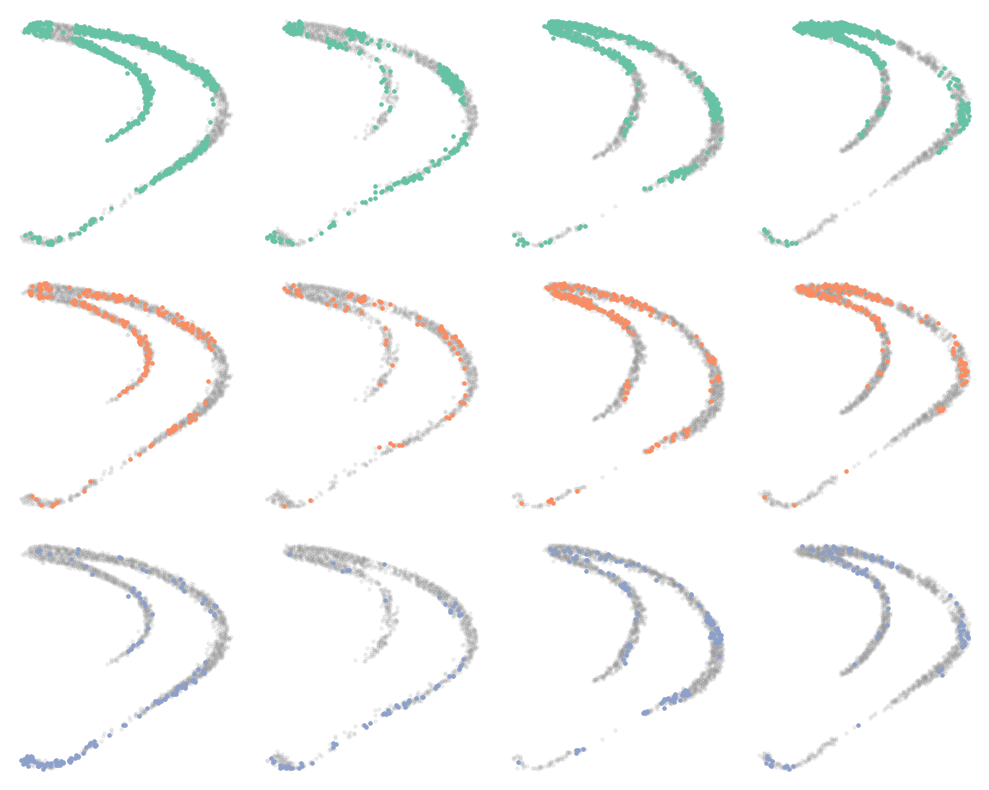

In [109]:
import scvelo as scv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 设置 Set2 调色板
set2_colors = sns.color_palette("Set2")
# 为已知类型指定颜色
palette = {'DG.Glut.0': set2_colors[0], 
           'DG.Glut.1': set2_colors[1], 
           'DG.Glut.2': set2_colors[2]}  # 为不同类型设置颜色

# 确保 RCTD 列是类别型
filtered_DG_PC1.obs['RCTD'] = filtered_DG_PC1.obs['RCTD'].astype('category')

# 获取所有在 RCTD 列中出现的类型
all_rctd_types = filtered_DG_PC1.obs['RCTD'].cat.categories

# 为未指定的类型分配默认颜色
default_color = 'gray'  # 默认颜色为灰色
for rctd_type in all_rctd_types:
    if rctd_type not in palette:
        palette[rctd_type] = default_color  # 给所有未在 palette 中的类型分配灰色

# 定义切片和类型
slices = ['NR1_2', 'NR2_2', 'DR1_2', 'DR2_2']
types = ['DG.Glut.0', 'DG.Glut.1', 'DG.Glut.2']

# 设置绘图区域：3行4列
fig, axs = plt.subplots(3, 4, figsize=(10, 8), constrained_layout=True)  # 使用axs

# 迭代每个切片和类型来生成子图
for i, slice_type in enumerate(slices):
    for j, t in enumerate(types):
        ax = axs[j, i]  # 获取对应的子图

        # 根据切片筛选数据
        slice_data = filtered_DG_PC1[filtered_DG_PC1.obs['slice'] == slice_type]
        
        # 检查slice_data是否为空
        if slice_data.shape[0] == 0:
            print(f"Warning: No data found for {slice_type}")
            continue
        
        # 将NaN值替换为0
        slice_data.X = np.nan_to_num(slice_data.X, nan=0)

        # 获取需要的坐标和颜色
        coordinates = slice_data.obsm['stereo']
        rctd_values = slice_data.obs['RCTD']

        # 先绘制所有点为灰色背景
        ax.scatter(coordinates[:, 0], coordinates[:, 1], c='gray', alpha=0.1, s=5)

        # 只绘制当前类型的点
        ax.scatter(coordinates[rctd_values == t, 0], 
                   coordinates[rctd_values == t, 1], 
                   c=palette[t], label=t, alpha=1.0, s=5)

        # 设置标题
        #ax.set_title(f'{slice_type} - {t}')
        
        # 设置不显示坐标轴
        ax.axis('off')
        
        # 显示图例
        #ax.legend(loc='lower center', fontsize=8, bbox_to_anchor=(0.5, -0.2), ncol=4)

# 设置布局并显示图形
plt.tight_layout()
plt.show()
#output_path = "F:/spatial/HIP/figures/DG_RCTD.pdf"
#plt.savefig(output_path, format='pdf', bbox_inches='tight')
#plt.close()
#print(f"PDF saved as {output_path}")

In [149]:
import matplotlib.pyplot as plt
import numpy as np
# 设置切片
slices = ['NR1_2', 'NR2_2', 'DR1_2', 'DR2_2']
slice_gene_sets = {
    'NR1_2': ['NR_DG Glut 0', 'NR_DG Glut 1', 'NR_DG Glut 2'],
    'NR2_2': ['NR_DG Glut 0', 'NR_DG Glut 1', 'NR_DG Glut 2'],
    'DR1_2': ['DR_DG Glut 0', 'DR_DG Glut 1', 'DR_DG Glut 2'],
    'DR2_2': ['DR_DG Glut 0', 'DR_DG Glut 1', 'DR_DG Glut 2']
}

# 创建一个4列3行的子图布局
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 8))
axes = axes.flatten()  # 将二维数组展平，方便索引

# 创建一个列表用于保存所有表达量，用于colorbar
all_expression_values = []

# 为了存储所有归一化后的表达量，我们需要一个字典
normalized_expression_dict = {}

for col_idx, slice_type in enumerate(slices):
    gene_sets_for_slice = slice_gene_sets[slice_type]
    slice_data = filtered_DGsg[filtered_DGsg.obs['slice'] == slice_type]
    
    for row_idx, gene_set_name in enumerate(gene_sets_for_slice):
        gene_set = gene_sets[gene_set_name]
        common_genes = list(set(gene_set) & set(slice_data.var_names))
        if not common_genes:
            continue
        
        sub = slice_data[:, common_genes]
        expr = sub.X.mean(axis=1).flatten()
        vmin = np.percentile(expr, 5)
        vmax = np.percentile(expr, 95)
        expr_clipped = np.clip(expr, vmin, vmax)
        
        coords = sub.obsm['stereo']  # shape = (n_cells, 2)
        
        # ===== 这里开始按表达值排序 =====
        order = np.argsort(expr_clipped)
        x_sorted = coords[order, 0]
        y_sorted = coords[order, 1]
        expr_sorted = expr_clipped[order]
        # ===== 排序结束，保证“蓝色点”先画，“红色点”后画 =====
        
        ax = axes[row_idx * 4 + col_idx]
        ax.scatter(
            x_sorted, 
            y_sorted, 
            c=expr_sorted,
            cmap='coolwarm',
            s=2,
            vmin=vmin, vmax=vmax
        )
        ax.axis('off')
        all_expression_values.extend(expr_clipped)

# 添加colorbar
#cbar_ax = fig.add_axes([0.1, -0.05, 0.8, 0.02])  # 重新调整colorbar的位置，使其不重叠
#norm = plt.Normalize(vmin=np.percentile(all_expression_values, 5), vmax=np.percentile(all_expression_values, 95))  # 设置colorbar的范围为5%-95%
#cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='coolwarm', norm=norm), cax=cbar_ax, orientation='horizontal')

# 设置colorbar的刻度，只显示起始和终止标签
#cbar.set_ticks([norm.vmin, norm.vmax])  # 设置colorbar的刻度
#cbar.set_ticklabels([f'5%', f'95%'])  # 设置刻度标签为5%和95%

# 手动调整布局，使得图像不与colorbar重叠
plt.subplots_adjust(bottom=0.02)

# 显示结果
#plt.show()
output_path = "F:/spatial/HIP/DG_ABC.pdf"
plt.savefig(output_path, format='pdf', bbox_inches='tight')
plt.close()
print(f"PDF saved as {output_path}")

PDF saved as F:/spatial/HIP/DG_ABC.pdf
